# Gaussian Test for ABI with compositional score matching

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from bayesflow import diagnostics
from torch.utils.data import DataLoader, Dataset

from diffusion_model import CompositionalScoreModel, SDE, weighting_function
from diffusion_sampling import euler_maruyama_sampling, adaptive_sampling, probability_ode_solving, langevin_sampling
from gaussian_flat_simulator import Prior, Simulator, visualize_simulation_output, generate_synthetic_data, sample_posterior, posterior_contraction
from helper_functions import generate_diffusion_time, count_parameters

/Users/jonas.arruda/miniconda/envs/hierarchical-abi/lib/python3.12/site-packages/bayesflow/trainers.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
torch_device = torch.device("cpu")

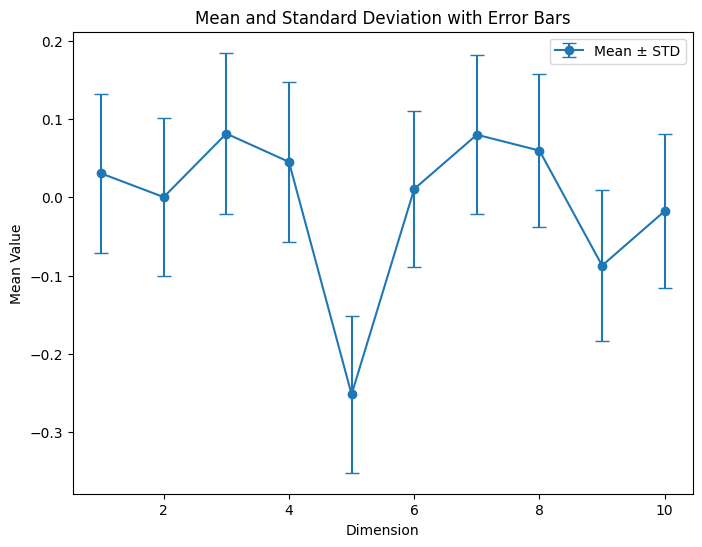

In [3]:
prior = Prior()
simulator_test = Simulator()

# test the simulator
prior_test = prior.sample(2)
sim_test = simulator_test(prior_test, n_obs=1000)
visualize_simulation_output(sim_test['observable'])

In [4]:
def compute_score_loss(theta_global_batch, x_batch, model, epsilon_global_batch=None):
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=theta_global_batch.shape[0],
                                             return_batch=True, device=theta_global_batch.device)

    # sample from the Gaussian kernel, just learn the noise
    if epsilon_global_batch is None:
        epsilon_global_batch = torch.randn_like(theta_global_batch, dtype=theta_global_batch.dtype,
                                                device=theta_global_batch.device)

    # perturb the theta batch
    alpha, sigma = model.sde.kernel(t=diffusion_time)
    z_global = alpha * theta_global_batch + sigma * epsilon_global_batch
    # predict from perturbed theta
    pred_global = model(theta_global=z_global, time=diffusion_time, x=x_batch, pred_score=False)

    effective_weight = weighting_function(diffusion_time, sde=model.sde, weighting_type=model.weighting_type,
                                          prediction_type=model.prediction_type)
    # calculate the loss (sum over the last dimension, mean over the batch)
    loss_global = torch.mean(effective_weight * torch.sum(torch.square(pred_global - epsilon_global_batch), dim=-1))
    return loss_global


# Training loop for Score Model
def train_score_model(model, dataloader, dataloader_valid=None, epochs=100, lr=1e-4, rectified_flow=False, device=None):
    print(f"Training {model.prediction_type}-model for {epochs} epochs with learning rate {lr} and {model.sde.kernel_type},"
          f" {model.sde.noise_schedule} schedule and {model.weighting_type} weighting.")
    if model.sde.noise_schedule == 'flow_matching':
        rectified_flow = True
    if rectified_flow:
        print(f'Using rectified flow.')
    print(f"Model has {model.n_params_global} parameters and is uses compositional conditioning with {model.max_number_of_obs} factors.")
    model.to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    # Add Cosine Annealing Scheduler
    #scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)

    # Training loop
    loss_history = np.zeros((epochs, 2))
    for epoch in range(epochs):
        model.train()
        total_loss = []
        # for each sample in the batch, calculate the loss for a random diffusion time
        for theta_global_batch, epsilon_global_batch, x_batch in dataloader:
            # initialize the gradients
            optimizer.zero_grad()
            theta_global_batch = theta_global_batch.to(device)
            x_batch = x_batch.to(device)
            if rectified_flow:
                epsilon_global_batch = epsilon_global_batch.to(device)
                # calculate the loss
                loss = compute_score_loss(theta_global_batch=theta_global_batch,
                                          epsilon_global_batch=epsilon_global_batch,
                                          x_batch=x_batch, model=model)
            else:
                # calculate the loss
                loss = compute_score_loss(theta_global_batch=theta_global_batch,
                                          x_batch=x_batch, model=model)
            loss.backward()
            # gradient clipping
            nn.utils.clip_grad_norm_(model.parameters(), 3.0)
            optimizer.step()
            total_loss.append(loss.item())
            dataloader.dataset.on_batch_end()
        #scheduler.step()
        dataloader.dataset.on_epoch_end()

        # validate the model
        model.eval()
        valid_loss = []
        if dataloader_valid is not None:
            with torch.no_grad():
                for theta_global_batch, epsilon_global_batch, x_batch in dataloader_valid:
                    theta_global_batch = theta_global_batch.to(device)
                    x_batch = x_batch.to(device)
                    if rectified_flow:
                        epsilon_global_batch = epsilon_global_batch.to(device)
                        # calculate the loss
                        loss = compute_score_loss(theta_global_batch=theta_global_batch,
                                                  epsilon_global_batch=epsilon_global_batch,
                                                  x_batch=x_batch, model=model)
                    else:
                        # calculate the loss
                        loss = compute_score_loss(theta_global_batch=theta_global_batch,
                                                  x_batch=x_batch, model=model)
                    valid_loss.append(loss.item())

        loss_history[epoch] = [np.mean(total_loss), np.mean(valid_loss)]
        print_str = f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(total_loss):.4f}, "\
                    f"Valid Loss: {np.mean(valid_loss):.4f}"
        print(print_str, end='\r')
        # Update the checkpoint after each epoch of training.
        #torch.save(model.state_dict(), 'ckpt.pth')
    return loss_history

In [5]:
class GaussianProblem(Dataset):
    def __init__(self, n_data, prior, online_learning=False, max_number_of_obs=1):
        # Create model and dataset
        self.prior = prior
        self.n_data = n_data
        self.max_number_of_obs = max_number_of_obs
        self.n_obs = max_number_of_obs
        self.online_learning = online_learning
        self.generate_data()

    def generate_data(self):
        # Create model and dataset
        self.thetas_global, self.xs = generate_synthetic_data(
            self.prior,
            data_size=self.max_number_of_obs if self.max_number_of_obs > 1 else None,
            n_samples=self.n_data, normalize=True
        )
        self.epsilon_global = torch.randn_like(self.thetas_global, dtype=torch.float32)

    def __len__(self):
        # this should return the size of the dataset
        return len(self.thetas_global)

    def __getitem__(self, idx):
        # this should return one sample from the dataset
        features = self.thetas_global[idx]
        if self.max_number_of_obs > 1:
            target = self.xs[idx, :self.n_obs]
        else:
            target = self.xs[idx]
        noise = self.epsilon_global[idx]
        return features, noise, target

    def on_epoch_end(self):  # for online learning
        # Regenerate data at the end of each epoch
        if self.online_learning:
            self.generate_data()

    def on_batch_end(self):
        # Regenerate data at the end of each epoch
        if self.max_number_of_obs > 1:
            # sample number of observations
            self.n_obs = np.random.randint(1, self.max_number_of_obs+1)

In [9]:
batch_size = 128
max_number_of_obs = 100

dataset = GaussianProblem(
    n_data=10000,
    prior=prior,
    online_learning=True,
    max_number_of_obs=max_number_of_obs
)
dataset_valid = GaussianProblem(
    n_data=batch_size*2,
    prior=prior,
    max_number_of_obs=max_number_of_obs
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

In [10]:
# Define model
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][0]
)

score_model = CompositionalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_x=prior.D,
    hidden_dim=128,
    n_blocks=3,
    max_number_of_obs=max_number_of_obs,
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    time_embed_dim=16,
    use_film=False,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior
)

print(score_model.name)
count_parameters(score_model)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

compositional_score_model_v_variance_preserving_linear_likelihood_weighting_factorized100
+------------------------------------+------------+
|              Modules               | Parameters |
+------------------------------------+------------+
|  summary_net.module.0.fc1.weight   |    1280    |
|   summary_net.module.0.fc1.bias    |    128     |
| summary_net.module.0.norm1.weight  |    128     |
|  summary_net.module.0.norm1.bias   |    128     |
|  summary_net.module.0.fc2.weight   |   16384    |
|   summary_net.module.0.fc2.bias    |    128     |
| summary_net.module.0.norm2.weight  |    128     |
|  summary_net.module.0.norm2.bias   |    128     |
|  summary_net.module.0.skip.weight  |    1280    |
|   summary_net.module.0.skip.bias   |    128     |
|  summary_net.module.1.fc1.weight   |   16384    |
|   summary_net.module.1.fc1.bias    |    128     |
| summary_net.module.1.norm1.weight  |    128     |
|  summary_net.module.1.norm1.bias   |    128     |
|  summary_net.module.1.fc

In [ ]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid,
                                 epochs=500, lr=1e-4, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(loss_history[:, 0], label='Mean Train')
plt.plot(loss_history[:, 1], label='Mean Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')
plt.show()

Training v-model for 500 epochs with learning rate 0.0001 and variance_preserving, linear schedule and likelihood_weighting weighting.
Model has 10 parameters and is uses compositional conditioning with 100 factors.


In [ ]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True))
score_model.eval();

In [ ]:
# check the error prediction: is it close to the noise?
loss_list_target = {}
loss_list_score = {}
loss_list_error_w_global = {}
loss_list_error = {}

with torch.no_grad():
    # Generate diffusion time and step size
    diffusion_time = generate_diffusion_time(size=100, device=torch_device)
    for t in diffusion_time:
        loss_list_target[t.item()] = 0
        loss_list_score[t.item()] = 0
        loss_list_error_w_global[t.item()] = 0
        loss_list_error[t.item()] = 0

        for theta_global_batch, _, x_batch in dataloader_valid:
            theta_global_batch = theta_global_batch.to(torch_device)
            x_batch = x_batch.to(torch_device)

            # sample from the Gaussian kernel, just learn the noise
            epsilon_global = torch.randn_like(theta_global_batch, dtype=torch.float32, device=torch_device)

            # perturb the theta batch
            t_tensor = torch.full((theta_global_batch.shape[0], 1), t,
                                  dtype=torch.float32, device=torch_device)
            # perturb the theta batch
            alpha, sigma = score_model.sde.kernel(t=t_tensor)
            snr = torch.log(torch.square(alpha)) - torch.log(torch.square(sigma))
            z_global = alpha * theta_global_batch + sigma * epsilon_global

            # predict from perturbed theta
            pred_epsilon_global = score_model(theta_global=z_global, time=t_tensor, x=x_batch, pred_score=False)
            pred_score_global = score_model(theta_global=z_global, time=t_tensor, x=x_batch, pred_score=True)
            true_score_global = score_model.sde.grad_log_kernel(x=z_global,
                                                                x0=theta_global_batch, t=t_tensor)

            if score_model.prediction_type == 'score':
                target_global = -epsilon_global / sigma
                pred_target_global = -pred_epsilon_global / sigma
            elif score_model.prediction_type == 'e':
                target_global = epsilon_global
                pred_target_global = pred_epsilon_global
            elif score_model.prediction_type == 'v':
                target_global = alpha*epsilon_global - sigma * theta_global_batch
                pred_target_global = alpha*pred_epsilon_global - sigma * theta_global_batch
            elif score_model.prediction_type == 'x':
                target_global = theta_global_batch
                pred_target_global = (z_global - pred_epsilon_global * sigma) / alpha
            else:
                raise ValueError("Invalid prediction type.")

            # calculate the loss (sum over the last dimension, mean over the batch)
            loss_global = torch.mean(torch.sum(torch.square(pred_target_global - target_global), dim=-1))
            loss = loss_global
            loss_list_target[t.item()] += loss.item()

            # calculate the error of the true score
            loss_global = torch.mean(torch.sum(torch.square(pred_score_global - true_score_global), dim=-1))
            loss = loss_global
            loss_list_score[t.item()] += loss.item()

            # calculate the weighted loss
            w = weighting_function(t_tensor, sde=score_model.sde,
                                   weighting_type=score_model.weighting_type, prediction_type=score_model.prediction_type)
            loss_global = torch.mean(w * torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss_list_error_w_global[t.item()] += loss_global.item()

            # check if the weighting function is correct
            loss_global = torch.mean(torch.sum(torch.square(pred_epsilon_global - epsilon_global), dim=-1))
            loss = loss_global
            loss_list_error[t.item()] += loss.item()

In [ ]:
df_target = pd.DataFrame(loss_list_target.items(), columns=['Time', 'Loss'])
df_score = pd.DataFrame(loss_list_score.items(), columns=['Time', 'Loss'])
df_error_w_global = pd.DataFrame(loss_list_error_w_global.items(), columns=['Time', 'Loss'])
df_error = pd.DataFrame(loss_list_error.items(), columns=['Time', 'Loss'])

# compute snr
snr = score_model.sde.get_snr(diffusion_time)
#upper_bound_loss = (np.sqrt(2) + 1) / (std.numpy()**2)

fig, ax = plt.subplots(ncols=4, sharex=True, figsize=(16, 3), tight_layout=True)
ax[0].plot(df_target['Time'], np.log(df_target['Loss']), label=f'Unscaled {score_model.prediction_type} Loss')
ax[1].plot(df_score['Time'], np.log(df_score['Loss']), label='Score Loss')
#ax[1].plot(df_score['Time'], df_score['Loss'] / upper_bound_loss, label='Score Loss')
ax[1].plot(diffusion_time, snr, label='log snr', alpha=0.5)
ax[2].plot(df_error_w_global['Time'], np.log(df_error_w_global['Loss']), label='Weighted Loss (as in Optimization)')
ax[3].plot(df_error['Time'], np.log(df_error['Loss']), label='Loss on Error')
for a in ax:
    a.set_xlabel('Diffusion Time')
    a.set_ylabel('Log Loss')
    a.legend()
plt.savefig(f'plots/{score_model.name}/losses_diffusion_time.png')
plt.show()

plt.figure(figsize=(6, 3), tight_layout=True)
plt.plot(diffusion_time.cpu(),
         weighting_function(diffusion_time, sde=score_model.sde, weighting_type=score_model.weighting_type,
                            prediction_type=score_model.prediction_type).cpu(),
         label='weighting')
plt.xlabel('Diffusion Time')
plt.ylabel('Weight')
plt.legend()
plt.show()

# Validation

In [ ]:
data_size = 10
valid_prior_global, valid_data = generate_synthetic_data(prior, n_samples=10, data_size=data_size,
                                                         normalize=False, random_seed=0)
param_names = ['$D_{' + str(i+1) + '}$' for i in range(prior.D)]
n_post_samples = 10
#score_model.current_number_of_obs = max_number_of_obs

In [ ]:
score_model.current_number_of_obs

In [ ]:
visualize_simulation_output(valid_data)

In [ ]:
sample_posterior_single = lambda vd: sample_posterior(
    vd,
    prior_sigma=prior.scale,
    sigma=prior.simulator.scale,
    n_samples=n_post_samples
)
posterior_global_samples_true = np.array([sample_posterior_single(vd) for vd in valid_data])

In [ ]:
diagnostics.plot_recovery(posterior_global_samples_true, np.array(valid_prior_global), param_names=param_names)
diagnostics.plot_sbc_ecdf(posterior_global_samples_true, np.array(valid_prior_global),
                          difference=True, param_names=param_names);

In [ ]:
posterior_global_samples_valid = np.array([langevin_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                             #n_scores_update=10,
                                                            diffusion_steps=300, langevin_steps=5, step_size_factor=0.05,
                                           device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_langevin_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_langevin_sampler.png')

In [ ]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   #n_scores_update=10,
                                                                   diffusion_steps=1000, device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sampler.png')

In [ ]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   n_scores_update=10,
                                                                   diffusion_steps=200, device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=[r'$\mu$', r'$\log \tau$'])
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler.png')

In [ ]:
posterior_global_samples_valid = np.array([euler_maruyama_sampling(score_model, vd, n_post_samples=n_post_samples,
                                                                   #n_scores_update=10,
                                                                   pareto_smooth_fraction=0.3,
                                                                   diffusion_steps=100, device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_pareto_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_pareto_sampler.png')

In [ ]:
posterior_global_samples_valid = np.array([adaptive_sampling(score_model, vd, n_post_samples,
                                                             #n_scores_update=10,
                                                             e_rel=1.5*0.1, max_steps=2000, device=torch_device)
                                        for vd in valid_data])

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler.png')

In [ ]:
posterior_global_samples_valid = np.zeros((len(valid_data), n_post_samples, 2))
for i, vd in enumerate(valid_data):
    # solve for every sample individually, much slower, and still most of the samples were similar
    #for j in range(n_post_samples):
    #    posterior_global_samples_valid[i, j] = probability_ode_solving(score_model, vd, n_post_samples=1,
    #                                                                    device=torch_device)
    # solve for all samples at once
    posterior_global_samples_valid[i] = probability_ode_solving(score_model, vd, n_post_samples=n_post_samples,
                                                                #n_scores_update=10,
                                                                device=torch_device)

In [ ]:
fig = diagnostics.plot_recovery(posterior_global_samples_valid, np.array(valid_prior_global), param_names=param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_ode.png')

fig = diagnostics.plot_sbc_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, param_names=param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_ode.png')

# Step Size for different Grid Sizes

In [ ]:
# check number of steps needed for different number of data points
n_steps = {}
n_steps_per_grid = {}
n_steps_error = {}

valid_id = 0
data_sizes = np.array([1, 10, 100, 1000]) * score_model.current_number_of_obs
if score_model.max_number_of_obs > 1:
    sampling_types = [('normal', None, 0.), ('subsample', 10, 0.)] #, ('pareto', None, 0.3)]
else:
    sampling_types = [('normal', None, 0.), ('subsample', 10, 0.)] #, ('pareto', None, 0.3)]

for sampling_type in sampling_types:
    print(sampling_type)
    n_steps[sampling_type[0]] = []
    n_steps_per_grid[sampling_type[0]] = []
    n_steps_error[sampling_type[0]] = []
    for n in data_sizes:
        true_params, valid_data = generate_synthetic_data(prior, n_samples=10, data_size=n,
                                                   normalize=False, random_seed=0)
        x_valid = valid_data[valid_id].to(torch_device)
        test_sample, list_steps = adaptive_sampling(score_model, x_valid, conditions=None, n_post_samples=1,
                                                    n_scores_update=sampling_type[1],
                                                    pareto_smooth_fraction=sampling_type[2],
                                    e_rel=1.5, max_steps=10000, t_end=0, random_seed=0, device=torch_device,
                                                    return_steps=True)
        #diffusion_steps = 1000#n**5
        #test_sample = euler_maruyama_sampling(score_model, x_valid, conditions=None, n_post_samples=1, diffusion_steps=diffusion_steps,
        #                                     t_end=0, random_seed=0, device=torch_device)
        #list_steps = [1/diffusion_steps] * diffusion_steps

        #plt.title(f'Number of data points: {n}x{n} Grid')
        #plt.plot(list_steps)
        #plt.show()
        n_steps_per_grid[sampling_type[0]].append(list_steps)
        n_steps[sampling_type[0]].append(len(list_steps))
        n_steps_error[sampling_type[0]].append(np.mean((test_sample-true_params[valid_id].numpy())**2))

In [ ]:
plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(data_sizes, n_steps[sampling_type[0]], 'o-', label=sampling_type[0])

if score_model.max_number_of_obs > 1:
    plt.title(f'Number of Steps for Different Grid Sizes ({score_model.current_number_of_obs} Obs)')
else:
    plt.title('Number of Steps for Different Grid Sizes')
#plt.plot(grid_sizes, n_steps, 'o-', label='#Steps')
plt.xlabel('#Obs')
plt.ylabel('Number of Steps')
plt.yscale('log')
plt.ylim(1, 1e4)
plt.legend()
plt.savefig(f'plots/{score_model.name}/number_of_steps_vs_grid_size{score_model.current_number_of_obs}.png')
plt.show()

plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(np.array(data_sizes)/score_model.current_number_of_obs,
             n_steps[sampling_type[0]], 'o-', label=sampling_type[0])

if score_model.max_number_of_obs > 1:
    plt.title(f'Number of Steps for Different #Obs ({score_model.current_number_of_obs} Obs)')
else:
    plt.title('Number of Steps for Different #Obs')
#plt.plot(grid_sizes, n_steps, 'o-', label='#Steps')
plt.xlabel('#Observations (divided by partial factorization)')
plt.ylabel('Number of Steps')
plt.yscale('log')
plt.ylim(1, 1e4)
plt.legend()
plt.savefig(f'plots/{score_model.name}/number_of_steps_vs_n_obs{score_model.current_number_of_obs}.png')
plt.show()

plt.figure(figsize=(5, 3), tight_layout=True)
for sampling_type in sampling_types:
    plt.plot(data_sizes, n_steps_error[sampling_type[0]], 'o-', label=sampling_type[0])
plt.title('Error for Different #Obs')
#plt.plot(grid_sizes, n_steps, 'o-', label='#Steps')
plt.xlabel('#Obs')
plt.ylabel('Mean Squared Error')
plt.yscale('log')
plt.legend()
plt.savefig(f'plots/{score_model.name}/error_vs_grid_size{score_model.current_number_of_obs}.png')
plt.show()

fig, ax = plt.subplots(1, len(sampling_types), sharey=True, figsize=(4*len(sampling_types), 4), tight_layout=True)
for a, sampling_type in zip(ax, sampling_types):
    a.set_title(sampling_type[0])
    for i, n in zip(data_sizes, n_steps_per_grid[sampling_type[0]]):
        a.plot(n, label=f'{i}x{i}')
    a.set_xlabel('Step')
    a.set_ylabel('Step Size')
    a.set_yscale('log')
    a.legend(loc='lower right')
    a.set_ylim(1e-6, 1)
plt.savefig(f'plots/{score_model.name}/n_steps_per_grid{score_model.current_number_of_obs}.png')
plt.show()

In [ ]:
# plot contraction factor
prior_std = prior.scale
likelihood_std = prior.simulator.scale

contractions = [posterior_contraction(prior_std, likelihood_std, n) for n in range(1, 1001)]
plt.figure(figsize=(5, 3), tight_layout=True)
plt.plot(contractions)
plt.title('Analytical Posterior Contraction')
plt.xlabel('Observations')
plt.ylabel('Factor')
plt.show()